In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import plotly.graph_objects as go
import pandas as pd
import cv2
import matplotlib.image as mpimg
import os
from PIL import Image
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import LayerNormalization, LeakyReLU, BatchNormalization
from tensorflow.keras.layers import LSTM

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
os.listdir("/content/drive/My Drive/comp4211")

['pa2', 'project']

In [ ]:
# Run: Local
folder_link = ""

In [26]:
# Run: Darren
folder_link = "/content/drive/My Drive/comp4211/project/"

In [ ]:
# Run: Newt
folder_link = "/content/drive/My Drive/HKUST/COMP 4211/Project/"

In [7]:
os.listdir(f"{folder_link}image_data/adausdt")
# os.listdir('/content/drive/My Drive/HKUST/COMP 4211/Project/image_data/adausdt')

['training_data.dat',
 'validation_data.dat',
 'testing_data.dat',
 'validation_output.csv',
 'testing_output.csv',
 'training_output.csv']

## Data Processing

In [21]:
train_data = []
train_output_arr = []
for coin in ["ada", "btc", "doge", "dot", "eth", "luna", "matic", "shib", "sol", "xrp"]:
    train_data.append(np.memmap(f"{folder_link}image_data/{coin}usdt/training_data.dat", dtype = np.uint8, mode = 'r').reshape((-1, 54, 72)))
    train_data.append(np.memmap(f"{folder_link}image_data/{coin}usdt/validation_data.dat", dtype = np.uint8, mode = 'r').reshape((-1, 54, 72)))
    train_output_arr.append(pd.read_csv(f"{folder_link}image_data/{coin}usdt/training_output.csv"))
    train_output_arr.append(pd.read_csv(f"{folder_link}image_data/{coin}usdt/validation_output.csv"))

train_data = np.concatenate(train_data)
print(train_data.shape)

(280437, 54, 72)


(54, 72)


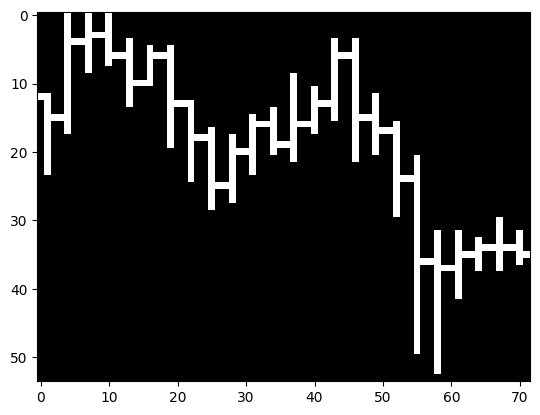

In [10]:
sample = train_data[0]
print(sample.shape)
plt.figure()
plt.imshow(sample, cmap="gray")

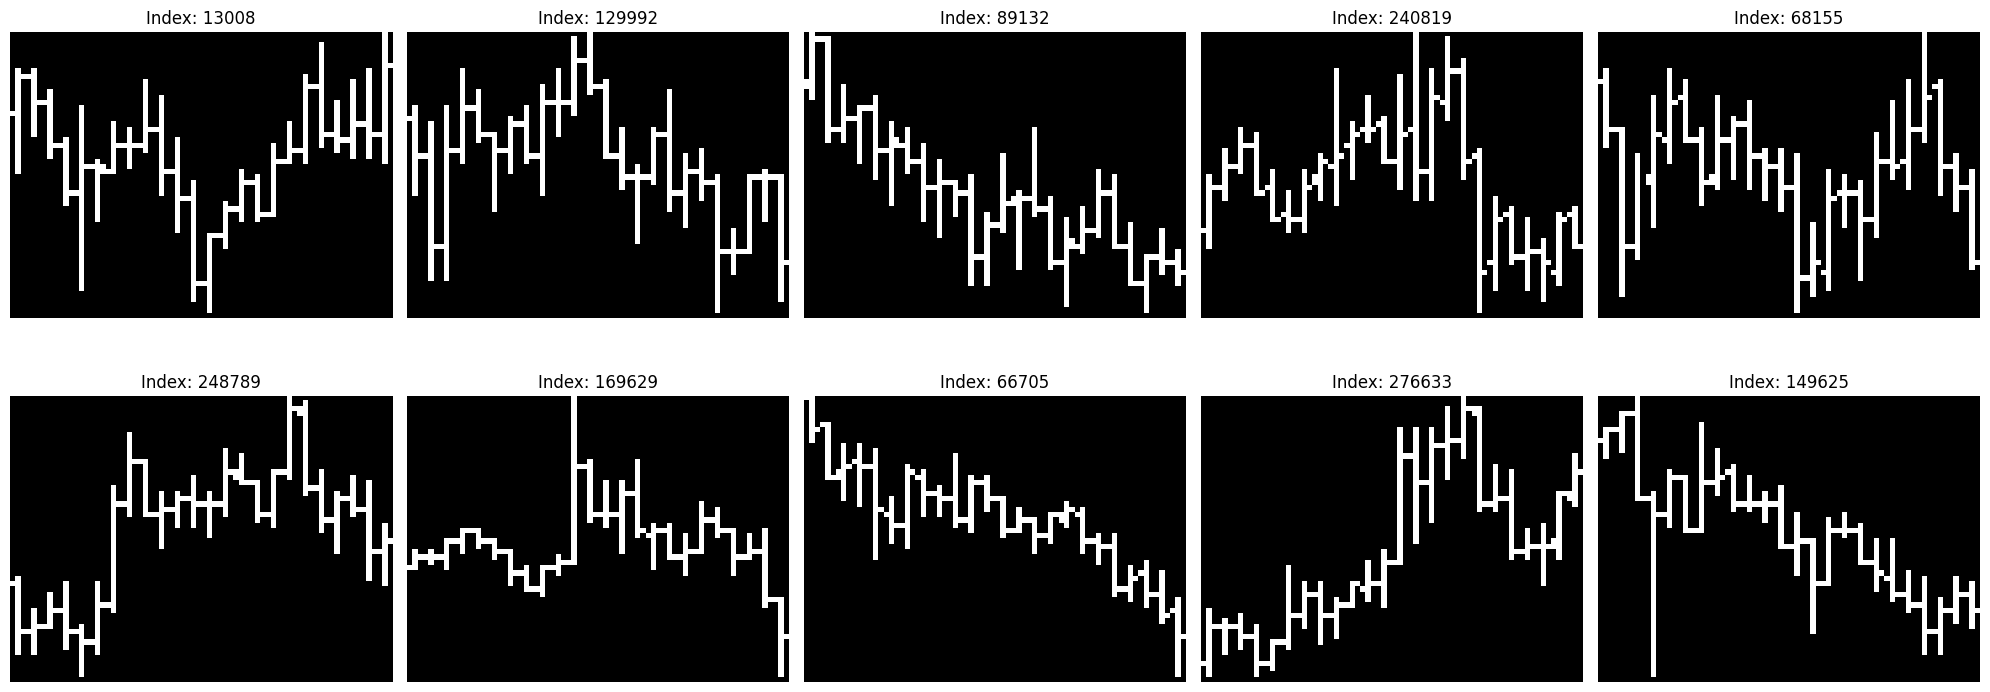

In [11]:
# Plot 10 random images and print their indices
fig, axs = plt.subplots(2, 5, figsize = (20, 8))
for i in range(10):
    index = np.random.randint(0, train_data.shape[0])
    axs[i // 5, i % 5].imshow(train_data[index], cmap = "gray")
    axs[i // 5, i % 5].set_title(f"Index: {index}")
    axs[i // 5, i % 5].axis("off")
plt.tight_layout()
plt.show()

In [22]:
def normalize(df):
    df["RollingMaxLR"] = df["LogReturns"].rolling(window = 24).apply(lambda x: np.max(x) - np.min(x))
    df["RollingMaxLR"] = df["RollingMaxLR"].fillna(df.loc[23, "RollingMaxLR"])
    df["NormalizedLogReturns"] = df["LogReturns"] / df["RollingMaxLR"]

for i in range(len(train_output_arr)):
    normalize(train_output_arr[i])

In [23]:
train_output = pd.concat(train_output_arr)
train_output

,Open time,LogReturns,RollingMaxLR,NormalizedLogReturns
0,1609545600000,-0.019493,0.094469,-0.206345
1,1609549200000,0.010832,0.094469,0.114658
2,1609552800000,0.004025,0.094469,0.042603
3,1609556400000,0.004180,0.094469,0.044247
4,1609560000000,-0.004065,0.094469,-0.043032
...,...,...,...,...
2154,1711908000000,0.002394,0.009461,0.253058
2155,1711911600000,0.002229,0.009461,0.235642
2156,1711915200000,-0.002070,0.009461,-0.218793
2157,1711918800000,-0.000638,0.008814,-0.072357


In [24]:
test_data = []
test_output_arr = []
for coin in ["ada", "btc", "doge", "dot", "eth", "luna", "matic", "shib", "sol", "xrp"] + ["bonk", "floki", "pepe", "wif"]:
    test_data.append(np.memmap(f"{folder_link}image_data/{coin}usdt/testing_data.dat", dtype = np.uint8, mode = 'r').reshape((-1, 54, 72)))
    test_output_arr.append(pd.read_csv(f"{folder_link}image_data/{coin}usdt/testing_output.csv"))

test_data = np.concatenate(test_data)
print(test_data.shape)

(70297, 54, 72)


In [25]:
for i in range(len(test_output_arr)):
    normalize(test_output_arr[i])

test_output = pd.concat(test_output_arr)
test_output

,Open time,LogReturns,RollingMaxLR,NormalizedLogReturns
0,1712016000000,-0.006622,0.042310,-0.156513
1,1712019600000,0.001943,0.042310,0.045916
2,1712023200000,-0.032046,0.042310,-0.757419
3,1712026800000,-0.005190,0.042310,-0.122678
4,1712030400000,-0.000168,0.042310,-0.003968
...,...,...,...,...
5106,1730397600000,-0.015255,0.043069,-0.354195
5107,1730401200000,-0.016758,0.043069,-0.389091
5108,1730404800000,0.006317,0.041514,0.152169
5109,1730408400000,0.003771,0.041514,0.090842


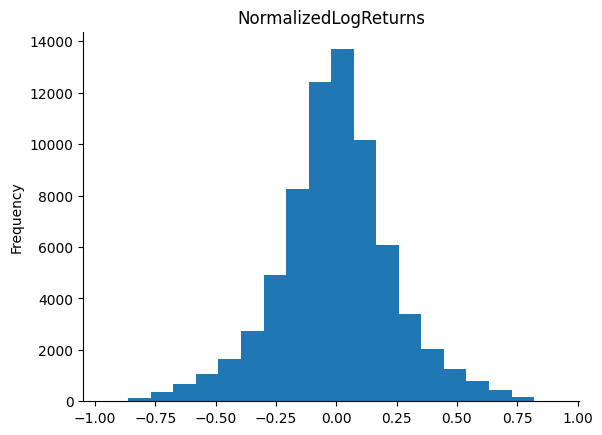

In [29]:
test_output['NormalizedLogReturns'].plot(kind='hist', bins=20, title='NormalizedLogReturns')
plt.gca().spines[['top', 'right',]].set_visible(False)

## Model

In [31]:
model = Sequential([
    # Layer 1
    Conv2D(32, kernel_size=(5, 3), padding='same', activation=None, input_shape=(54, 72, 1)),
    BatchNormalization(),
    LeakyReLU(alpha=0.01),
    MaxPooling2D(pool_size=(3, 1)),
    Dropout(0.5),

    # Layer 2
    Conv2D(64, kernel_size=(5, 3), padding='same', activation=None),
    BatchNormalization(),
    LeakyReLU(alpha=0.01),
    MaxPooling2D(pool_size=(3, 1)),
    Dropout(0.5),

    # Layer 3
    Conv2D(128, kernel_size=(5, 3), padding='same', activation=None),
    BatchNormalization(),
    LeakyReLU(alpha=0.01),
    MaxPooling2D(pool_size=(3, 1)),
    Dropout(0.5),

    # Fully connected layer
    Flatten(),
    Dense(256),
    Dropout(0.5),
    Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)                    │ (None, 54, 72, 32)          │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_9                │ (None, 54, 72, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_9 (LeakyReLU)            │ (None, 54, 72, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 18, 72, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_12 (Dropout)                 │ (None, 18, 72, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 18, 72, 64)          │          30,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_10               │ (None, 18, 72, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_10 (LeakyReLU)           │ (None, 18, 72, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 6, 72, 64)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_13 (Dropout)                 │ (None, 6, 72, 64)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 6, 72, 128)          │         123,008 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_11               │ (None, 6, 72, 128)          │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_11 (LeakyReLU)           │ (None, 6, 72, 128)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 2, 72, 128)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_14 (Dropout)                 │ (None, 2, 72, 128)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 18432)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 256)                 │       4,718,848 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_15 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,874,305 (18.59 MB)

 Trainable params: 4,873,857 (18.59 MB)

 Non-trainable params: 448 (1.75 KB)

In [ ]:
X = train_data.reshape((-1, 54, 72, 1))
y = train_output["NormalizedLogReturns"].values
early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
model.fit(X, y, epochs=10, validation_split=0.2, callbacks=[early_stopping])

model.save("model.h5")
model = tf.keras.models.load_model("model.h5")

Epoch 1/10
4202/7011 ━━━━━━━━━━━━━━━━━━━━ 28s 10ms/step - loss: 154.5840

In [ ]:
# Make predictions
X_train = train_data.reshape((-1, 54, 72, 1))
y_pred = model.predict(X_train).flatten()

# Calculate the loss
loss = np.mean((y_pred - train_output["NormalizedLogReturns"].values) ** 2)
print(f"Loss: {loss}")

# Compare loss against benchmark
benchmark_loss = np.mean((train_output["NormalizedLogReturns"].values) ** 2)
print(f"Benchmark Loss: {benchmark_loss}")

8089/8089 ━━━━━━━━━━━━━━━━━━━━ 19s 2ms/step
Loss: 0.05642794656857429
Benchmark Loss: 0.05628091904922915


In [ ]:
X_test = test_data.reshape((-1, 54, 72, 1))
y_pred = model.predict(X_test).flatten()

# Calculate the loss
loss = np.mean((y_pred - test_output["NormalizedLogReturns"].values) ** 2)
print(f"Loss: {loss}")

# Compare loss against benchmark
benchmark_loss = np.mean((test_output["NormalizedLogReturns"].values) ** 2)
print(f"Benchmark Loss: {benchmark_loss}")